# LSTM으로 음악 생성해보기

### YBIGTA 22기 XXX

## 1. Introduction

LSTM은 string의 series가 들어왔을 때 다음에 나올 string을 예측하는 역할을 할 수 있습니다.

MIDI라는 파일 규격을 통해 컴퓨터에서 음악을 작곡하고 재생할 수 있습니다. MIDI 파일은 명령어를 통해 '피아노로 도를 치고 드럼으로 몇 박자를 치는' 등의 악보를 기술할 수 있습니다. 이는 string 형태이므로 LSTM을 적용하기에 좋은 예제가 됩니다.

파이썬의 music21 라이브러리를 활용하면 MIDI 데이터를 전처리하고 시각화할 수 있습니다.

Original code: https://www.kaggle.com/code/karnikakapoor/music-generation-lstm/data

## 2. GPU 사용 설정
런타임 -> 런타임 유형 변경 -> 하드웨어 가속기 GPU로 반드시 설정해주세요!

In [1]:
# GPU 확인: GPU 이름과 GPU 메모리 점유율 확인하기
!nvidia-smi -L
!nvidia-smi

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-4075fb2a-8676-6864-644c-210f37c0fad0)
GPU 1: NVIDIA GeForce RTX 3090 (UUID: GPU-da19f084-f799-c3d2-2fde-3d611a4f8faf)
Tue Jan 31 07:00:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 38%   29C    P8    21W / 350W |      1MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------

## 3. 현재 런타임에 데이터 업로드, 압축 풀기
구글 드라이브에 마운트하는 대신 현재 런타임에 데이터를 업로드해서 사용하시면 됩니다. 파일은 교육세션 드라이브에 업로드 되어있으니 로컬로 다운받으신 후 업로드하시면 됩니다.
1. 파일 -> 세션 저장소의 업로드 버튼 클릭 (구글 드라이브 마운트 버튼 기준 왼쪽에 있습니다.)
2. chopin.zip 파일 업로드
3. 아래의 리눅스 명령어로 압축 해제

In [2]:
!unzip -qq 'chopin.zip'

## 4. Dependency 설치
1. 설치된 패키지들 업데이트
2. lilypond (음악 악보편집) 패키지 설치
3. music21 (MIDI 라이브러리) 설치

* '!'를 앞에 붙이면 리눅스 명령어를 실행하게 됩니다.

In [ ]:
!sudo apt-get update -y
!sudo apt-get install -y lilypond
!pip install music21

Get:1 https://deb.nodesource.com/node_12.x bionic InRelease [4584 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1581 B]
Err:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Get:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:7 https://deb.nodesource.com/node_12.x bionic/main amd64 Packages [768 B]  
Get:8 http://archive.ubuntu.com/ubuntu bionic InRelease [242 kB]               
Get:9 https://developer.download.nvidia.com/compute/ma

## 5. 필요한 라이브러리 import

In [5]:
import tensorflow
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
import os
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

2023-01-31 07:04:14.501737: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.7/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.7) doesn't match a supported version!
  RequestsDependencyWarning)


## 6. 업로드한 MIDI 파일들 불러오기

In [6]:
filepath = "./chopin/"
#Getting midi files
all_midis= []
for i in tqdm(os.listdir(filepath)):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

100%|██████████| 48/48 [04:06<00:00,  5.14s/it]


## 7. Note 추출하기
음표는 음악의 building block의 역할을 합니다. 본 예제의 MIDI 파일은 피아노 음악만을 포함하고 있으므로 이를 음표의 형태로 추출하게 됩니다.

앞서 MIDI 파일들을 모아놓은 `all_midis` 리스트를 순회하며 음표들을 추출하고, 이를 리스트에 넣어 return하는 함수를 정의합니다.

### music21 library
모든 코드를 이해할 필요는 없지만 `partitionByInstrument()` 등의 메소드가 궁금하다면 `music21` 라이브러리의 공식 document를 참고하시면 됩니다. https://web.mit.edu/music21/doc/moduleReference/moduleInstrument.html

*참고: NLP에서 모델 학습을 위한 말뭉치를 `Corpus`라고 합니다. 아래에서 추출한 note들의 리스트가 Corpus의 역할을 합니다.

In [7]:
# Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in tqdm(file):
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

# Getting the list of notes as Corpus
Corpus = extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

100%|██████████| 48/48 [00:16<00:00,  2.84it/s]

Total notes in all the Chopin midis in the dataset: 57887


In [8]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['8.9', '8.9', '7.8', '8.1', '8.9.1', 'E4', '8.1', '4.8', 'E-6', '1.3.8', '9.1', 'G#5', '1.6', '6.8.1', 'A3', '4.6', 'E-5', '8.1', '1.3.8', 'E4', '8.1', '9.1', 'G#4', '1.6', '6.8.1', 'A3', '4.6', 'E-4', '8.1', '1.3.8', 'E3', '11.1', 'A3', 'G#3', '0.3', 'G#2', '8.10.1', '8.0.3', 'G#3', '1.4.8', '0.3.6', 'G#2', 'E4', '8', '8.1', '8.9.1', '4.8', 'E-6', 'E4', '8.1']


### 이제 corpus의 형태로 training data를 가지고 있습니다. 위에 보이는 각각의 string이 음표라고 생각하면 됩니다.
## 8. Data Exploration
### Printing the music sheet

Changing working directory to: `/tmp/music21'
Processing `/tmp/music21/tmp3iemv58f.ly'
Parsing...
Interpreting music...[8][16][24][32][40]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `tmp3iemv58f.ly.eps'...
Converting to PNG...
Layout output to `tmp3iemv58f.ly-1.eps'...
Layout output to `tmp3iemv58f.ly-2.eps'...
Layout output to `tmp3iemv58f.ly-3.eps'...
Layout output to `tmp3iemv58f.ly-4.eps'...
Layout output to `tmp3iemv58f.ly-5.eps'...
Layout output to `tmp3iemv58f.ly-6.eps'...
Layout output to `tmp3iemv58f.ly-7.eps'...
Writing tmp3iemv58f.ly-systems.texi...
Writing tmp3iemv58f.ly-systems.tex...
Writing tmp3iemv58f.ly-systems.count...
Success: compilation successfully completed


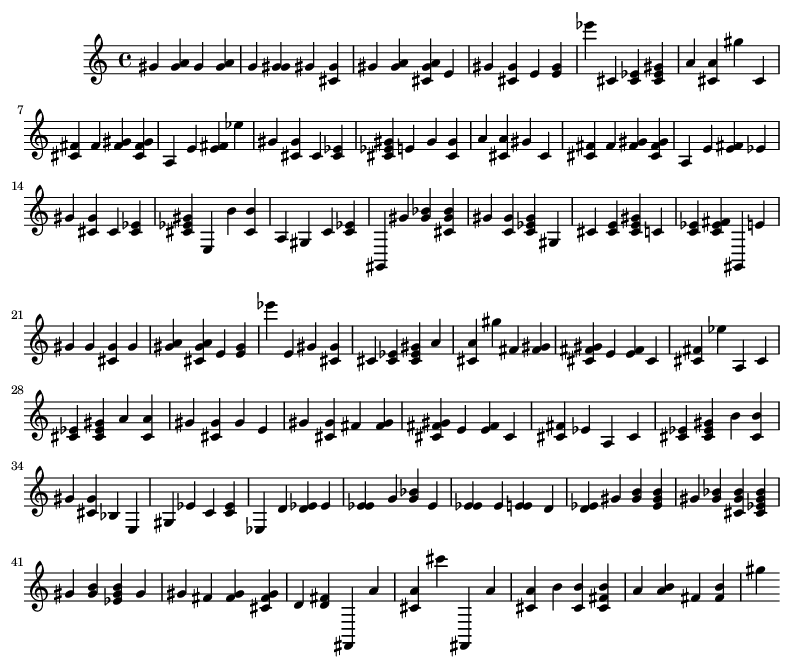

In [9]:
# First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

### 전체 Corpus에 존재하는 음표의 개수를 확인해 봅니다.

[참고] `Counter` 클래스를 모른다면?
https://docs.python.org/ko/3/library/collections.html#collections.Counter

Counter 클래스는 입력으로 들어온 Iterable에서 각 원소가 몇 번씩 나오는지를 알려주는 객체를 생성합니다. 딕셔너리처럼 key를 이용하여 값을 읽을 수 있고, 특정 key가 Counter에 존재하는지도 확인할 수 있습니다. 아래는 예시입니다.
``` Python
>>> Counter(["hi", "hey", "hi", "hi", "hello", "hey"])
Counter({'hi': 3, 'hey': 2, 'hello': 1})
```

In [10]:
# Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 397


## 음표의 등장 빈도를 확인해 봅니다.
특정 멜로디에서 자주 등장하는 음표가 있을 것이고, 어떤 음표의 경우에는 아주 가끔씩만 등장할 것입니다. RNN / LSTM 모델링에서 빈도가 너무 낮게 등장하는 경우에는 문제가 발생합니다. 따라서 발생 빈도를 살펴보도록 합시다.

In [11]:
# Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())

# Average recurrence for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrence for a note in Corpus: 145.8110831234257
Most frequent note in Corpus appeared: 1627 times
Least frequent note in Corpus appeared: 1 time


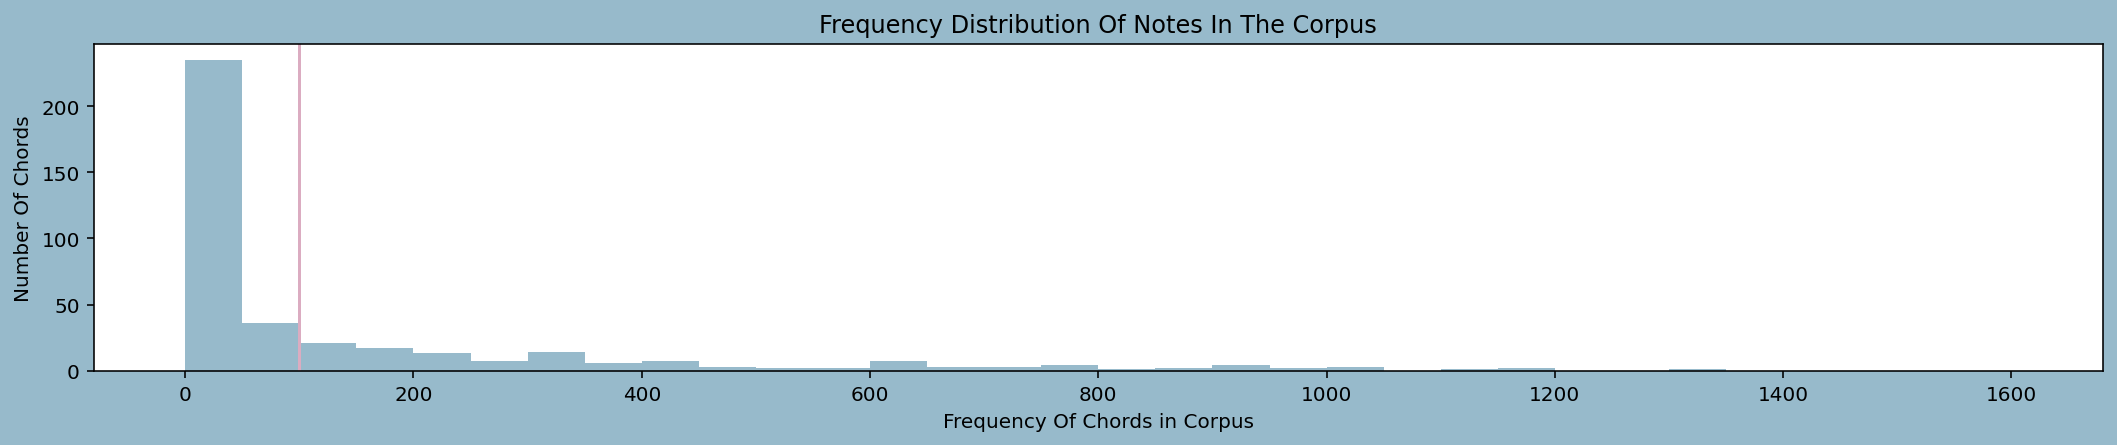

In [12]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

### 100번 미만으로 등장한 음표들은 제거
`count_num` 객체에서 iteration을 하면서 `key`, `value`를 뽑아냅니다. `key`는 음표를 나타내는 string이고 `value`는 해당 음표가 등장한 횟수입니다. 따라서 등장 횟수가 100번 미만이면 `rare_note`라는 리스트에 집어넣어서 나중에 제거합니다.

In [13]:
# Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 271


In [14]:
# Rare note에 해당하는 음표들을 제거해 줍니다.
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 53712


##  9. Data Prepreocessing
음표들을 LSTM에 집어넣으려면 모두 인코딩을 해줘야 합니다. NLP에서 단어를 각각 벡터로 표현해준 것과 유사합니다. 순서는 다음과 같습니다.

1. <b>Dictionary 생성</b>: 우선 각각의 음표를 index로 mapping해주는 dictionary를 만들어야 합니다. 음표는 string으로 표현되므로 각각의 string을 index로 바꾸어주면 됩니다.
2. <b>Encodding and Splitting the corpus</b>: Corpus를 1번에서 만든 dictionary를 이용하여 인코딩 해주고, 다음으로 이를 동일한 길이의 sequence로 쪼개주어야 합니다.
3. <b>Assigning X and y</b>: Label을 resize하고 normalize 해주고, target은 one-hot encoding을 해줍니다.

* Reverse mapping을 굳이 따로 정의해주는 것은 시간 복잡도 관점에서 생각하면 됩니다. 만약 이를 정의하지 않는다면 디코딩 과정에서 매번 loop를 돌아야 하므로 비효율적입니다.

### Dictionary 생성

In [15]:
# Storing all the unique characters present in my corpus to bult a mapping dic.
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) # length of corpus
L_symb = len(symb) # length of total unique characters

# Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 53712
Number of unique characters: 266


## [중요!] Encodding and Splitting the Corpus
RNN 기반의 아키텍쳐를 사용할 때 가장 헷갈리는 부분입니다. RNN이나 LSTM은 input 데이터의 dimension을 정확하게 맞춰주어야 하는데, 이 과정이 조금 까다롭습니다. 😞 참고로 아래 이미지와 같이 고정된 길이의 sequence를 가지고 다음에 나올 부분을 예측하고, 그대로 한 칸 이동해서 동일한 방식으로 training이 진행됩니다. 흔히 말하는 sliding window 방식입니다.

참고: https://data-analysis-expertise.tistory.com/67

Keras LSTM documentation: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

![image](https://www.researchgate.net/publication/350511416/figure/fig1/AS:1007244028174337@1617157098300/LSTM-sliding-window-prediction-principle.png)

우선, RNN에 들어가는 input은 반드시 (batch, timesteps, feature)으로 3개의 차원을 가져야 합니다. 
- Batch: 전체 데이터의 개수를 의미합니다.
- Timesteps: Input data의 sequence 길이를 말합니다. 예를 들어 30일동안의 주가를 바탕으로 다음 날의 주가를 예측하고 싶다고 하면 sequence length가 30이 될 것입니다.
- Feature: Input (X)에서 feature의 수를 의미합니다. 일반적으로 1이고, 만약 주식 가격 예측에서 open, high, low, close 가격을 모두 사용해서 close를 예측하겠다면 4가 될 것입니다.

아래 모델에서는 40개의 음표를 가지고 다음 음표를 예측하는 task를 수행할 것입니다. 따라서 timesteps는 40이 됩니다. 실제로 문제를 풀다보면 timesteps만 잘 정해주면 나머지 두 개의 차원은 생각할 필요는 없습니다. Reshape만 잘 해서 차원을 맞춰주면 됩니다.


In [16]:
# Splitting the Corpus in equal length of strings and output target
# 앞서 설명한 sliding window 방식으로 데이터를 생성해주는 과정입니다.
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]  # i번째부터 40개의 음표 string
    target = Corpus[i + length]  # 40개의 음표 바로 다음의 음표 string
    features.append([mapping[j] for j in feature])  # 40개를 모두 index로 바꾼 뒤 리스트에 넣어서 append
    targets.append(mapping[target])  # 예측 대상인 음표도 index로 바꾼 뒤 append
    
    
L_datapoints = len(targets)  # 결국 window를 계속 움직이며 총 target개의 예측을 수행해야 한다.
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 53672


In [17]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1))) / float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

In [18]:
# Batch, timesteps, features
X.shape, y.shape

((53672, 40, 1), (53672, 266))

In [19]:
# Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

## 10. LSTM layer 구성하기
keras에서 `Sequential` 모델을 생성한 뒤, 모델에 layer를 하나씩 넘겨주면 쉽게 구현할 수 있습니다.

참고: https://tykimos.github.io/2017/04/09/RNN_Getting_Started/
- LSTM: 출력 벡터의 차원, input shape를 넘겨주면 됩니다. 이때 `return_sequences`는 마지막 sequence에서 output을 한 번만 출력할지 여부를 결정해 줍니다. LSTM을 여러 개 쌓거나 many to many 문제를 푼다면 `True`로 지정해주면 됩니다.
- Dropout: Overfitting 문제를 해결하기 위해 input에 dropout을 적용합니다. Dropout은 training 과정에서만 수행하고 inference 과정에서는 해제해줘야 하는데, 이후에 `model.fit()` 함수에서 자동으로 이를 해결해 줍니다.
- Dense: Fully Connected (FC) layer를 구성합니다. 이전 layer인 LSTM layer에서 길이가 256인 벡터를 반환하므로 input shape는 자동으로 256이 됩니다. 따라서 output shape만 256으로 지정해주면 됩니다.
- Adamax optimizer: Adam optimizer의 변형 중 하나로, time-variant한 task에서 주로 사용됩니다.
- `model.compile`: Training을 하기에 앞서서 loss와 optimizer 등을 지정해주고, 앞서 구성한 layer들을 모두 합쳐서 모델을 구성하게 됩니다.

In [20]:
#Initialising the Model
model = Sequential()  # Keras에서 layer를 선형으로 연결할 때 사용

# 필요한 layer들을 하나하나 추가해 준다
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
# Compiling the model for training
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

2023-01-31 07:10:06.661730: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-01-31 07:10:06.721780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-01-31 07:10:06.722459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:25:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-01-31 07:10:06.722481: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-01-31 07:10:06.729885: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

In [21]:
# Model's Summary               
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 512)           1052672   
_________________________________________________________________
dropout (Dropout)            (None, 40, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 266)               68362     
Total params: 1,974,282
Trainable params: 1,974,282
Non-trainable params: 0
______________________________________________

## 11. Training

혹시라도 중간에 OOM (Cuda out of memory) 오류가 난다면 런타임을 재시작하고 다시 돌리셔야 합니다. nvidia-smi 결과에서 GPU 메모리 점유율을 확인해 보세요.

In [22]:
# Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

2023-01-31 07:10:14.220698: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-31 07:10:14.223866: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2349935000 Hz


Epoch 1/200


2023-01-31 07:10:16.016430: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-01-31 07:10:16.537554: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2023-01-31 07:10:16.680993: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


  1/168 [..............................] - ETA: 8:22 - loss: 5.5877

2023-01-31 07:10:17.112917: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-01-31 07:10:17.113037: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


168/168 [==============================] - 5s 13ms/step - loss: 4.7270
Epoch 2/200
168/168 [==============================] - 2s 13ms/step - loss: 4.6862
Epoch 3/200
168/168 [==============================] - 2s 13ms/step - loss: 4.6818
Epoch 4/200
168/168 [==============================] - 2s 13ms/step - loss: 4.6466
Epoch 5/200
168/168 [==============================] - 2s 13ms/step - loss: 4.4757
Epoch 6/200
168/168 [==============================] - 2s 13ms/step - loss: 4.4544
Epoch 7/200
168/168 [==============================] - 2s 13ms/step - loss: 4.4384
Epoch 8/200
168/168 [==============================] - 2s 13ms/step - loss: 4.4370
Epoch 9/200
168/168 [==============================] - 2s 13ms/step - loss: 4.4229
Epoch 10/200
168/168 [==============================] - 2s 13ms/step - loss: 4.4108
Epoch 11/200
168/168 [==============================] - 2s 13ms/step - loss: 4.4024
Epoch 12/200
168/168 [==============================] - 2s 13ms/step - loss: 4.3896
Epoch 13/200


[Text(0.5, 0, 'Epochs')]

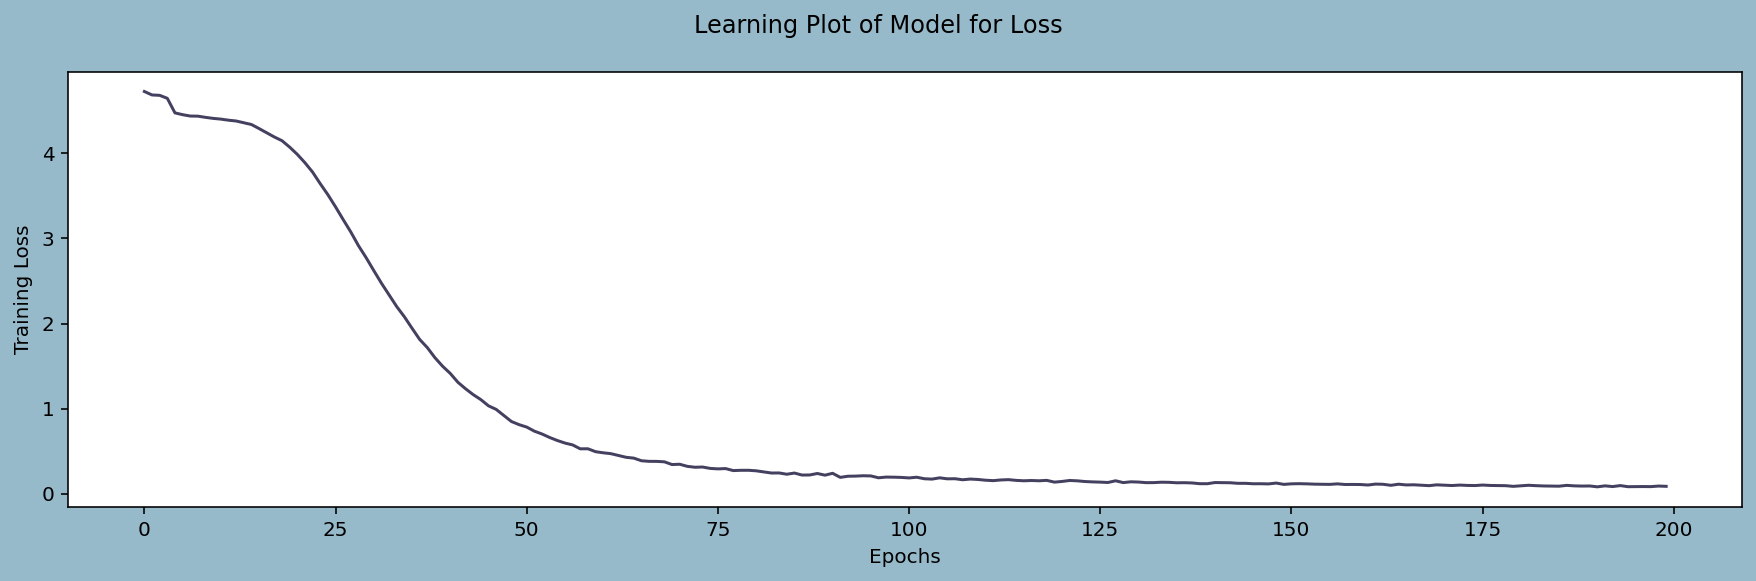

In [23]:
# Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

## Training이 완료된 모델로 멜로디 생성

Changing working directory to: `/tmp/music21'
Processing `/tmp/music21/tmp8u7zb67m.ly'
Parsing...
Interpreting music...[8][16][24]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `tmp8u7zb67m.ly.eps'...
Converting to PNG...
Layout output to `tmp8u7zb67m.ly-1.eps'...
Layout output to `tmp8u7zb67m.ly-2.eps'...
Layout output to `tmp8u7zb67m.ly-3.eps'...
Layout output to `tmp8u7zb67m.ly-4.eps'...
Writing tmp8u7zb67m.ly-systems.texi...
Writing tmp8u7zb67m.ly-systems.tex...
Writing tmp8u7zb67m.ly-systems.count...
Success: compilation successfully completed


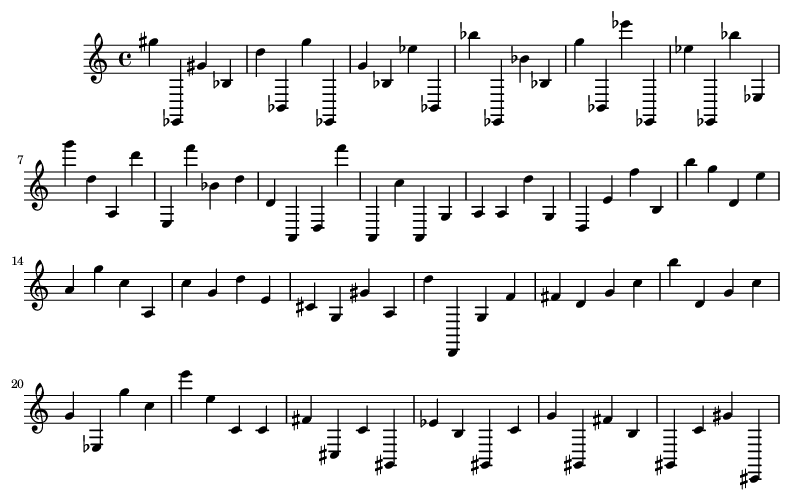

In [24]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 # diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    # Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


# Getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)
show(Melody)

In [26]:
# 생성된 멜로디를 저장 (자동으로 다운로드 되니 본인 기수, 이름만 집어넣으면 됩니다.)
#from google.colab import files
file_name = 'melody_22기_김지훈.mid'
Melody.write('midi', file_name)

#files.download(file_name)

'melody_22기_김지훈.mid'

## 과제 1: 생성된 MIDI file을 mp3 파일로 변환 후 업로드
다음 링크에서 변환 후 이 ipynb 파일과 함께 Github에 업로드 해주세요.
https://audio.online-convert.com/convert-to-mp3

## 과제 2: RNN, LSTM 관련 간단한 문제

문항이 있는 cell에 답을 바로 입력해서 같이 제출해 주시면 됩니다. [ANSWER] 토큰을 지우고 답을 적으시면 됩니다. 발제 자료에 없는 내용이 있다면 구글링을 통해 해결하시면 됩니다.


## Question 1 (True / False)
1. RNN에 hidden layer를 더 많이 추가하면 vanishing gradient 문제를 해결할 수 있다: False

2. RNN에서 L2-regularization을 추가하면 vanishing gradient 문제를 해결할 수 있다: False

## Question 2 (Long answer)

[참고] 장문의 답변을 쓸 필요는 없습니다. 핵심만 간단하게 서술하셔도 됩니다. 

1. RNN과 기존의 MLP, CNN 모델의 차이점을 서술하시오: </br> 

(1) 고정된 입력 데이터 크기를 요구하는 MLP, CNN과 달리 RNN은 입력 데이터의 크기가 가변적이다. (2) RNN은 시간순 정보를 활용한다.



2. RNN에서 activation function으로 `tanh`를 사용하는 이유를 서술하시오: </br> 

(1) sigmoid에 비해 기울기 소실 문제에 강하다. (2) ReLU에 비해 기울기 폭발 문제에 강하다.



3. RNN에서 hidden state가 하는 역할이 무엇인가요?: </br> 

시간순 데이터에 따라 재귀적으로 활동하여 이전 시점의 값을 기반으로 현재 시점의 출력값을 연산하고 자신의 값을 다음 시점으로 전달한다.



4. RNN에서 일어나는 vanishing gradient 문제가 무엇인지, 그리고 그 원인이 무엇인지 설명하시오: </br>

모델 학습 중 역전파가 진행될수록 1보다 작은 값으로 이루어진 기울기 matrix를 거듭하여 곱함에 따라 기울기 값이 0에 가까워져 앞부분의 loss가 제대로 반영되지 못하는 문제다.



5. (Open question) RNN 모델들은 앞에서 들어온 내용들을 보고 다음을 예측하는 방식으로 동작합니다. 그러나 sequence에서 앞부분만이 아니라 뒷부분의 내용을 참고해서 output을 만들어내야 하는 경우가 있습니다. 이처럼 뒷부분 내용을 반영하여 sequence를 처리하는 모델의 구조를 생각하고 간단하게 설명해 보세요: </br> Hint: Bidirectional LSTM 키워드로 구글링</br>

Bidirectional LSTM: 순방향으로 정보를 추출하는 일반적인 LSTM 모델과 달리 역방향으로도 정보를 추출할 수 있도록 LSTM을 양방향으로 겹쳐 놓은 구조다.


# Submission format
1. RNN_22기_XXX.ipynb (과제 2, 3에 대한 답도 같이 포함)
2. melody_22기_XXX.mp3

## Question 3 (Optional)
## Pytorch로 RNN 구현해보기

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

/opt/homebrew/Caskroom/miniforge/base/envs/pt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. RNN 구현
Pytorch로 neural network 모델을 구현할 때에는 `nn.Module`을 상속받아서 구현하게 됩니다. 

### [참고] 객체지향 개념을 잘 모른다면?
객체지향 개념을 잘 모르신다면 <b>상속</b>이란 상속을 받은 클래스 (여기서는 CustomRNN)가 부모 클래스 (`nn.Module`)의 멤버 변수와 메소드를 그대로 넘겨받아 필요에 맞게 재정의하거나 기타 필요한 기능들을 추가해서 사용하는 행위로 쉽게 이해하시면 됩니다. 이를 통해 코드의 중복도를 낮추고 보다 효율적인 설계를 할 수 있습니다. 

예를 들어서 `nn.Module` 클래스를 상속받아 만든 모든 클래스들은 `__init()__` 생성자와 `forward()` 메소드를 구현함으로써 모든 neural network가 high level에서는 동일한 동작을 함을 보장할 수 있습니다.

만약 상속 기능을 사용하지 않는다면 모델을 training하는 코드, inference를 하는 코드 등을 neural network 종류마다 새로 짜야 하므로 복잡해집니다.

### 구현 관련 배경지식
`nn.Module` 클래스를 상속받으면 `__init__()` 생성자와 `forward()` 메소드를 구현해야 합니다. 생성자에서는 모델에서 사용할 기본적인 멤버 변수들을 초기화하게 됩니다. 여기서 멤버 변수로는 크게 두 가지가 있습니다.
1. 모델 아키텍쳐와 관련된 dimension들 (각각의 의미는 발제 PPT 참고)
 - Input vector의 길이
 - Hidden layer의 길이
 - Output vector의 길이
 - Batch size


2. 모델에서 사용될 layer들
 - Pytorch의 `nn` module에서는 neural network에서 사용되는 다양한 layer를 미리 구현해 두었습니다. Convolution layer, pooling layer, linear layer 등이 정의되어 있어서 복잡한 연산을 직접 구현할 필요가 없습니다. 본 과제에서는 해당 layer를 쌓아서 RNN을 구현한다고 보시면 됩니다.
 - 본 과제에서는 Linear layer만 활용하면 됩니다. 이는 MLP 세션에서 배운 fully connected layer와 같습니다. FC layer이므로 input, output의 size와 bias 사용 유무만 정의해주면 됩니다. https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear


생성자를 정의했으면 `forward()` 함수를 정의할 차례입니다. `forward()` 메소드가 모델 구현에서 핵심입니다. 이 메소드는 모델에 input data를 집어넣으면 자동으로 호출되고 argument로 input이 전달됩니다. 앞서 정의한 layer들을 잘 호출해서 메소드를 구현하시면 됩니다.


*Backward pass는 모델 train을 할 때 `backward()`가 알아서 해주기 때문에 `forward()`만 정의하는 것입니다.

In [2]:
# nn.Module을 상속받아서 CustomRNN class 정의

class CustomRNN(nn.Module):
    """
    RNN basic block
    """
    def __init__(self, input_size, hidden_size, output_size):
        """
        input_size: Input vector 길이
        hidden_size: Hidden state vector 길이
        output_size: Output vector 길이
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.W_xh = nn.Linear(input_size, hidden_size, bias=False)
        
        ##################################################################
        # TODO: 필요한 멤버 변수 2개를 추가로 정의하세요.
        #
        # 1. W_hh: hidden layer vector에 곱해지는 weight
        # 2. W_hy: hidden layer로 output을 생성할 때 곱해지는 weight
        #
        # Hint: 위의 self.W_xh 코드를 참고하세요.
        #
        ##################################################################
        # 아래 주석 해제 후 정의하시면 됩니다. bias는 둘 다 True로 해주세요.
        self.W_hh = nn.Linear(hidden_size, hidden_size, bias=True)
        self.W_hy = nn.Linear(hidden_size, output_size, bias=True)
        ##################################################################
        #                         END OF YOUR CODE                       #
        ##################################################################
        
    def forward(self, x, hidden_state):
        W_xh_x = self.W_xh(x)  # W_xh weight에 input x를 곱해준 결과
        ##################################################################
        # TODO: Forward pass를 계산하는 코드를 추가하세요.
        #
        ########################### 전체 과정 ##############################
        #
        # 1. W_xh와 input을 곱한다.
        # 2. W_hh와 {t - 1} 시점에서의 hidden state vector를 곱한다.
        # 3. 둘이 더한다.
        # 4. tanh를 통과시켜서 새로운 hidden state를 만들어낸다.
        # 5. W_hy와 새로운 hidden state를 곱해서 output을 만들어낸다.
        # 6. output과 새로운 hidden state를 return한다.
        #
        # Hint: torch.tanh
        #
        ##################################################################
        # 아래 주석 해제 후 추가하시면 됩니다.
        W_hh_x = self.W_hh(hidden_state)
        hidden_state = torch.tanh(W_xh_x + W_hh_x)
        output = self.W_hy(hidden_state)
        ##################################################################
        #                         END OF YOUR CODE                       #
        ##################################################################
        # 아래 주석도 해제하세요.
        return output, hidden_state

## 2. 아래 코드에서 Correct가 나오면 완료입니다.

In [3]:
model = CustomRNN(5, 6, 7)
model_str = str(model).splitlines()
import numpy
stack = []
for i in range(1, 4):
    stack.append(int(model_str[i][29]))
    stack.append(int(model_str[i][45]))

prod = numpy.prod(stack)

if prod == 45360:
    print("Correct!!!")
else:
    print("Incorrect...")

Correct!!!
